In [1]:
import tweepy
import pandas as pd

In [2]:
# API Key setup
api_key = 'XLrT4TY4C8ZdIFQOMri1QX6Cc'
api_secret_key = 'nFdnp9YT30Omojj9JZdtqD6j6qKP6vvuo65FjLOt6Fe0eotwpZ'
access_token = '3083368926-c7fXpsH0k1Hrqs6bNe7954RMMp7viwgK7paRuHX'
access_token_secret = 'bTTr0tiF4Xizcnjj7gGS1efzhSN5Co8Cgcc0P1cHjMXeF'
# Bearer token from Twitter API v2
bearer_token = 'AAAAAAAAAAAAAAAAAAAAAJttvwEAAAAAve3ZMFPG3IVh5poNuakDQUxLo%2Fw%3DcdUn78VL26nE15hTVzu9hjKEl1raNd8xRnvL00uVVloJABXMSD'

In [3]:
# Authenticate to Twitter
auth = tweepy.OAuthHandler(api_key, api_secret_key)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [4]:
import tweepy
import logging

# Create client for Twitter API v2
client = tweepy.Client(bearer_token=bearer_token)

# Query tweets using the v2 API
query = 'attrition risk OR employee turnover OR workplace stress OR HR issues lang:en'
response = client.search_recent_tweets(query=query, tweet_fields=['created_at', 'author_id', 'text'], max_results=100)

# Store tweet details in a DataFrame
tweet_data = []
for tweet in response.data:
    tweet_data.append([tweet.created_at, tweet.author_id, tweet.text])

df_tweets = pd.DataFrame(tweet_data, columns=['Timestamp', 'Author_ID', 'Tweet'])

# Display first few rows
print(df_tweets.head())


                  Timestamp   Author_ID  \
0 2024-09-16 10:35:28+00:00   185086854   
1 2024-09-16 10:33:44+00:00    62797848   
2 2024-09-16 10:32:35+00:00   538940166   
3 2024-09-16 10:24:40+00:00  2790753125   
4 2024-09-16 10:22:40+00:00  1431482203   

                                               Tweet  
0  RT @Fuel_YourGrowth: Leaving a toxic workplace...  
1  You may already be aware of the high level of ...  
2  RT @Fuel_YourGrowth: Leaving a toxic workplace...  
3  RT @kimbafuzz: This echos some of my own feeli...  
4  RT @Fuel_YourGrowth: Leaving a toxic workplace...  


In [5]:
import re

def clean_tweet(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)     # Remove mentions
    text = re.sub(r'#', '', text)        # Remove hashtags
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove special characters
    return text.strip().lower()

df_tweets['Cleaned_Tweet'] = df_tweets['Tweet'].apply(clean_tweet)
print(df_tweets[['Tweet', 'Cleaned_Tweet']].head())


                                               Tweet  \
0  RT @Fuel_YourGrowth: Leaving a toxic workplace...   
1  You may already be aware of the high level of ...   
2  RT @Fuel_YourGrowth: Leaving a toxic workplace...   
3  RT @kimbafuzz: This echos some of my own feeli...   
4  RT @Fuel_YourGrowth: Leaving a toxic workplace...   

                                       Cleaned_Tweet  
0  rt  leaving a toxic workplace is an act of bra...  
1  you may already be aware of the high level of ...  
2  rt  leaving a toxic workplace is an act of bra...  
3  rt  this echos some of my own feelings this be...  
4  rt  leaving a toxic workplace is an act of bra...  


In [6]:
from transformers import pipeline

# Load sentiment-analysis pipeline
sentiment_model = pipeline('sentiment-analysis')

# Apply sentiment analysis
df_tweets['Sentiment'] = df_tweets['Cleaned_Tweet'].apply(lambda tweet: sentiment_model(tweet)[0]['label'])

print(df_tweets[['Cleaned_Tweet', 'Sentiment']].head())


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


                                       Cleaned_Tweet Sentiment
0  rt  leaving a toxic workplace is an act of bra...  POSITIVE
1  you may already be aware of the high level of ...  POSITIVE
2  rt  leaving a toxic workplace is an act of bra...  POSITIVE
3  rt  this echos some of my own feelings this be...  NEGATIVE
4  rt  leaving a toxic workplace is an act of bra...  POSITIVE


C:\Users\hp\AppData\Local\Temp\ipykernel_22288\472202984.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


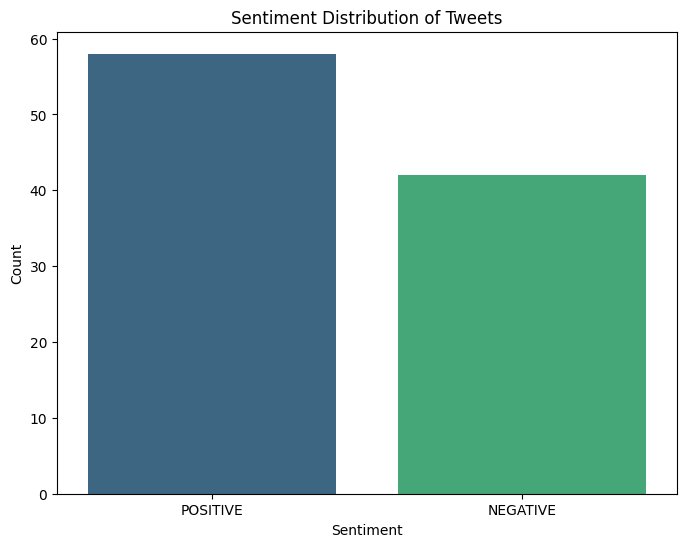

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the sentiment occurrences
sentiment_counts = df_tweets['Sentiment'].value_counts()

# Plot the sentiment distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution of Tweets')
plt.show()


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=500)
X = vectorizer.fit_transform(df_tweets['Cleaned_Tweet'])

# Convert to DataFrame
df_features = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Assuming you have labels for training
y = df_tweets['Sentiment'] 

# Split data
X_train, X_test, y_train, y_test = train_test_split(df_features, y, test_size=0.3, random_state=42)

# Train a Random Forest model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

    NEGATIVE       0.88      1.00      0.93        14
    POSITIVE       1.00      0.88      0.93        16

    accuracy                           0.93        30
   macro avg       0.94      0.94      0.93        30
weighted avg       0.94      0.93      0.93        30



In [10]:
import time
import logging
import pandas as pd

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

def process_tweets():
    tweet_count = 0
    max_tweets = 5
    
    while tweet_count < max_tweets:
        start_time = time.time()
        
        try:
            # Fetch new tweets
            fetch_start = time.time()
            response = client.search_recent_tweets(query=query, tweet_fields=['created_at', 'author_id', 'text'], max_results=10)
            if response.data is None:
                logger.warning("No tweets found.")
                time.sleep(60)  # Sleep and retry if no tweets
                continue
            fetch_time = time.time() - fetch_start
            
            # Process and clean tweets
            process_start = time.time()
            new_tweets = pd.DataFrame([[tweet.created_at, tweet.author_id, tweet.text] for tweet in response.data], columns=['Timestamp', 'Author_ID', 'Tweet'])
            new_tweets['Cleaned_Tweet'] = new_tweets['Tweet'].apply(clean_tweet)
            process_time = time.time() - process_start
            
            # Extract features
            feature_start = time.time()
            new_features = vectorizer.transform(new_tweets['Cleaned_Tweet'])
            df_new_features = pd.DataFrame(new_features.toarray(), columns=vectorizer.get_feature_names_out())
            feature_time = time.time() - feature_start
            
            # Predict attrition risk
            predict_start = time.time()
            predictions = model.predict(df_new_features)
            predict_time = time.time() - predict_start
            
            # Output predictions and increment tweet_count
            for tweet, prediction in zip(new_tweets['Tweet'], predictions):
                if tweet_count < max_tweets:
                    print(f"Tweet: {tweet}\nPrediction: {prediction}\n")
                    tweet_count += 1
                else:
                    break
            
            # Log times
            logger.info(f"Fetch time: {fetch_time:.2f} seconds")
            logger.info(f"Process time: {process_time:.2f} seconds")
            logger.info(f"Feature extraction time: {feature_time:.2f} seconds")
            logger.info(f"Prediction time: {predict_time:.2f} seconds")
        
        except Exception as e:
            logger.error(f"An error occurred: {e}")
            break
        
        if tweet_count < max_tweets:
            # Sleep for a while before fetching new tweets
            time.sleep(60)  # Fetch new tweets every 1 minute
    
    print("Processed 5 tweets. Exiting...")

# Run the real-time processing function
process_tweets()


INFO:root:Fetch time: 0.68 seconds
INFO:root:Process time: 0.00 seconds
INFO:root:Feature extraction time: 0.00 seconds
INFO:root:Prediction time: 0.01 seconds


Tweet: RT @Fuel_YourGrowth: Leaving a toxic workplace is an act of bravery, not a sign of defeat!

According to MIT, having a toxic work culture i…
Prediction: POSITIVE

Tweet: You may already be aware of the high level of service we provide to support our clients with regards to #HR and #EmploymentLaw issues. But did you know we also offer specialist services in #Outplacement? Get in touch to find out more https://t.co/eMnQ5vaujV 🔗 https://t.co/KZgyklpbiu
Prediction: POSITIVE

Tweet: RT @Fuel_YourGrowth: Leaving a toxic workplace is an act of bravery, not a sign of defeat!

According to MIT, having a toxic work culture i…
Prediction: POSITIVE

Tweet: RT @kimbafuzz: This echos some of my own feelings. This being the anniversary of BM’s passing…. I kinda wish it had just been about remembe…
Prediction: NEGATIVE

Tweet: RT @Fuel_YourGrowth: Leaving a toxic workplace is an act of bravery, not a sign of defeat!

According to MIT, having a toxic work culture i…
Prediction: POSITIVE

Process

### Applying LLM --> GPT2

In [11]:
from transformers import pipeline

# Initialize the sentiment-analysis pipeline
sentiment_model = pipeline('sentiment-analysis')


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [12]:
# Apply sentiment analysis using the LLM
df_tweets['LLM_Sentiment'] = df_tweets['Cleaned_Tweet'].apply(lambda tweet: sentiment_model(tweet)[0]['label'])

print(df_tweets[['Cleaned_Tweet', 'LLM_Sentiment']].head())


                                       Cleaned_Tweet LLM_Sentiment
0  rt  leaving a toxic workplace is an act of bra...      POSITIVE
1  you may already be aware of the high level of ...      POSITIVE
2  rt  leaving a toxic workplace is an act of bra...      POSITIVE
3  rt  this echos some of my own feelings this be...      NEGATIVE
4  rt  leaving a toxic workplace is an act of bra...      POSITIVE


In [13]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# Initialize GPT-2 model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [16]:
def generate_topics(text, max_input_length=50, max_new_tokens=20):
    # Truncate the input text if it's longer than the max_input_length
    inputs = tokenizer.encode(text[:max_input_length], return_tensors='pt')
    
    # Generate topics with a set number of new tokens
    outputs = model.generate(inputs, max_new_tokens=max_new_tokens, num_return_sequences=1)
    
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Apply topic generation to the cleaned tweets
df_tweets['Generated_Topics'] = df_tweets['Cleaned_Tweet'].apply(generate_topics)

# Display the results
print(df_tweets[['Cleaned_Tweet', 'Generated_Topics']].head())


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

                                       Cleaned_Tweet  \
0  rt  leaving a toxic workplace is an act of bra...   
1  you may already be aware of the high level of ...   
2  rt  leaving a toxic workplace is an act of bra...   
3  rt  this echos some of my own feelings this be...   
4  rt  leaving a toxic workplace is an act of bra...   

                                    Generated_Topics  
0  rt  leaving a toxic workplace is an act of bra...  
1  you may already be aware of the high level of ...  
2  rt  leaving a toxic workplace is an act of bra...  
3  rt  this echos some of my own feelings this be...  
4  rt  leaving a toxic workplace is an act of bra...  


In [26]:
def process_tweets_with_llm():
    tweet_count = 0  # Counter for the number of tweets processed
    
    while tweet_count < 5:  # Loop until 5 tweets are processed
        # Fetch new tweets
        response = client.search_recent_tweets(query=query, tweet_fields=['created_at', 'author_id', 'text'], max_results=10)
        
        # Process and clean tweets
        new_tweets = pd.DataFrame([[tweet.created_at, tweet.author_id, tweet.text] for tweet in response.data], columns=['Timestamp', 'Author_ID', 'Tweet'])
        new_tweets['Cleaned_Tweet'] = new_tweets['Tweet'].apply(clean_tweet)
        
        # Apply LLM sentiment analysis
        new_tweets['LLM_Sentiment'] = new_tweets['Cleaned_Tweet'].apply(lambda tweet: sentiment_model(tweet)[0]['label'])
        
        # Output results
        for tweet, sentiment in zip(new_tweets['Tweet'], new_tweets['LLM_Sentiment']):
            print(f"Tweet: {tweet}\nLLM Sentiment: {sentiment}\n")
            tweet_count += 1
            if tweet_count >= 5:
                break
        
        # If 5 tweets have been printed, exit the loop
        if tweet_count >= 5:
            break

# Run the real-time processing function with LLM
process_tweets_with_llm()

Tweet: RT @mercer: When political discourse takes place in the office, it can trigger workplace incivility resulting in higher rates of stress amo…
LLM Sentiment: NEGATIVE

Tweet: RT @BirkbeckUoL: Do you know the difference between stress and #burnout? 

In this #BirkbeckExplains, Prof Almuth McDowall &amp; Dr @kevinteohr…
LLM Sentiment: NEGATIVE

Tweet: Do you know the difference between stress and #burnout? 

In this #BirkbeckExplains, Prof Almuth McDowall &amp; Dr @kevinteohrh talk about the tell-tale differences between the two in the workplace and beyond. 🧠  https://t.co/OZucSU9pcN 

@BBK_Business @bbkpsychology
LLM Sentiment: NEGATIVE

Tweet: When political discourse takes place in the office, it can trigger workplace incivility resulting in higher rates of stress among employees. Explore ways in which employers can foster positive work behaviors to uphold workplace civility. https://t.co/akuyPRsgu4 #wellbeing https://t.co/72NnviWzC4
LLM Sentiment: NEGATIVE

Tweet: Another sympto